In [356]:
# IMPORT LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader

In [357]:
# READ CSV DATA INTO A PANDAS DATAFRAME AND ADD HEADER NAMES TO COLUMNS

df = pd.read_csv('ratings_Electronics.csv', names = ['userId', 'productId', 'rating', 'timestamp'])

In [358]:
# CHECK THE DATA

df.head(10)

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


## Exploratory Data Analysis

In [359]:
# CHECK SHAPE OF THE DATA

df.shape

(7824482, 4)

In [360]:
# CHECK MISSING VALUES

df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [361]:
# DROP timestamp COLUMN

df.drop('timestamp', axis=1, inplace=True)

In [362]:
df.shape

(7824482, 3)

In [363]:
# CHECK DATATYPES OF COLUMNS.

df.dtypes

userId        object
productId     object
rating       float64
dtype: object

In [364]:
# The dataset contains around 7.8M records and 3 columns (userId, productId and rating).
# rating is a numerical column which is correct and others are of datatype object.

In [365]:
# Get mean, median and quartiles of the rating column.

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D4AD9F6160>]],
      dtype=object)

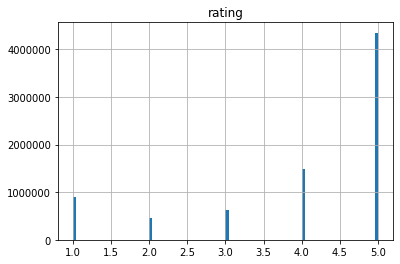

In [366]:
# Plot a histogram for the rating column's data distribution.

df.hist(column='rating', bins=100)

In [367]:
df['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [368]:
# 'rating' column
# No fractional value exists in the column. All the values are whole numbers from 1 to 5.

In [369]:
df['userId'].value_counts().sum()

7824482

In [370]:
# Store all unique values of userId in counts variable.

counts = df['userId'].value_counts()

In [371]:
counts

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
A25C2M3QF9G7OQ    296
A22CW0ZHY3NJH8    292
A38RMU1Y5TDP9     282
A3EXWV8FNSSFL6    282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A231WM2Z2JL0U3    252
A12DQZKRKTNF5E    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
A203OCQQ12MAVT    240
AEJAGHLC675A7     239
A2NYK9KWFMJV4Y    238
A3A4ZAIBQWKOZS    236
A3CW0ZLUO5X2B1    227
                 ... 
A1HYXSOH4FZJBO      1
A2096LW0VTHNZV      1
A2GBA9KB5ITDTP      1
A3SUKFT7ATI7X       1
A3TVC6O2RGMZOT      1
A25X87Q1UP62SN      1
A1M451JQK28QMO      1
A2UV1O5212BK2D      1
A34AK5I5TNAP5Y      1
A2ESLP6YU4K67F      1
A2X3ZZ57HHL8SJ      1
ADCSZJJB718NH       1
A2XMEA2EELPGEU      1
A1OOCC6Z4J4SKW      1
ASX3ZKYWDB

In [372]:
counts[counts >= 50].sum()

125871

In [373]:
# Consider only those users who have rated 50 or more than 50 products.
df = df[df['userId'].isin(counts[counts >= 50].index)]

In [374]:
df.shape

(125871, 3)

In [375]:
# The size of the dataframe df now comes down to only 125871 records.
# Apply popularity and collaborative filtering recommendation algorithms on this dataframe.

## Popularity Based Recommendation System

In [376]:
df.groupby('productId')['rating'].mean().head()

productId
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: rating, dtype: float64

In [377]:
df.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: rating, dtype: float64

In [378]:
df.groupby('productId')['rating'].count().sort_values(ascending=False).head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: rating, dtype: int64

In [379]:
# Popularity based recommendation system build up using mean rating of each product.

popularityRCM = pd.DataFrame(df.groupby('productId')['rating'].mean())

In [380]:
# Using count of all ratings for every product.

popularityRCM['rating_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())

In [381]:
# To have both 1.mean rating and 2.count of ratings into consideration, it would be better to consider a metric
# which is a multiplication of both mean and count of ratings for each product.

for index, row in popularityRCM.iterrows():
    popularityRCM['rating_sum'] = popularityRCM['rating'] * popularityRCM['rating_count']

In [382]:
popularityRCM.sort_values('rating_sum', ascending=False).head()

,rating,rating_count,rating_sum
productId,,,
B003ES5ZUU,4.864130,184,895.0
B0088CJT4U,4.218447,206,869.0
B000N99BBC,4.772455,167,797.0
B007WTAJTO,4.701220,164,771.0
B00829TIEK,4.436242,149,661.0


In [383]:
# Get the final listing of products based on popularity.
# In my thinking, this approach of computing would be better instead of ranking just on the mean rating in descending order.

popularityRCM = popularityRCM.sort_values('rating_sum', ascending=False)

In [384]:
# Top 5 Popularity Based Recommender System
popularityRCM.head()

,rating,rating_count,rating_sum
productId,,,
B003ES5ZUU,4.864130,184,895.0
B0088CJT4U,4.218447,206,869.0
B000N99BBC,4.772455,167,797.0
B007WTAJTO,4.701220,164,771.0
B00829TIEK,4.436242,149,661.0


## Collaborative Filtering Recommendation System

### User-User Based Collaborative Filtering

In [385]:
print('Dataframe shape: ', df.shape)
print("Total unique users: ", df.userId.unique().shape[0])
print("Total unique products: ", df.productId.unique().shape[0])

Dataframe shape:  (125871, 3)
Total unique users:  1540
Total unique products:  48190


In [386]:
# Create training and test datasets from df in the ratio of 70:30.

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size=.30)

In [387]:
# Use user_based parameter to true for user-based collaborative filtering.
# Using k = 50.

algorithm = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algorithm.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [388]:
# Computing Similarity matrix among users, the values of which range between 0 and 1.

print("Similarity Matrix among users\n")
m = algorithm.compute_similarities().shape;
print("\nShape: ", m, "\n")
print(algorithm.compute_similarities())

# Training data contains all the unique users existing in the original dataset. Count of 1540 users.

Similarity Matrix among users

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Shape:  (1540, 1540) 

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
[[ 1.         -0.01352671  0.         ...  0.          0.
   0.        ]
 [-0.01352671  1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [389]:
# Baselines matrix

print(algorithm.compute_baselines()[0].shape[0])
print(algorithm.compute_baselines()[1].shape[0])
print(algorithm.compute_baselines()[0])
print(algorithm.compute_baselines()[1])

1540
38130
[-0.22487937 -0.09574118  0.14515158 ... -0.42207124  0.4371781
 -0.35963138]
[ 0.10235659 -0.01486625 -0.30949285 ...  0.06208461  0.07708611
 -0.02687634]


In [390]:
# Predict a random combination of a user and a product.

algorithm.predict('A17HMM1M7T9PJ1', '0970407998')

Prediction(uid='A17HMM1M7T9PJ1', iid='0970407998', r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

In [391]:
# Function to compute top n User-User based recommendations

def userBasedRecommendations(userIdRaw, n):
    print("Getting inner ID from raw user ID.")
    userIdInner = algorithm.trainset.to_inner_uid(userIdRaw)
    
    print("Getting 20 nearest neighbors for the user.")
    neighbors = algorithm.get_neighbors(userIdInner, 20)
    
    print("Getting raw IDs of neighbors.")
    neighborsRaw = []
    index = 0
    for nb in neighbors:
        neighborsRaw.append(algorithm.trainset.to_raw_uid(neighbors[index]))
        index = index + 1
    print("Nearest neighbors: ", neighborsRaw)
    
    print("Getting a subset of the original dataset where neighbors are the only users in it.")
    index = 0
    neighbordf = df[(df.userId == '')]
    for neighbor in neighborsRaw:
        neighbordf = neighbordf.append(df[(df.userId == neighbor)])
    #Now we have the subset of all the products rated by the neighbors.
    #print(neighbordf)
    print("Neighbor dataset shape: ", neighbordf.shape)
    #print(neighbordf.productId.value_counts())
    
    print("Getting a subset of the original dataset only for the user whose ID is passed to this function.")
    userdf = df[df.userId == userIdRaw]
    print ('So user {0} has already rated {1} products.'.format(userIdRaw, userdf.shape[0]))
    #print(userdf)
    
    print("Removing products from neighbordf which has already been rated by the user.")
    neighbordf2 = df[(df.userId == '')]
    neighbordf2 = neighbordf[~neighbordf['productId'].isin(userdf['productId'])]
    print("Neighbor dataset shape: ", neighbordf2.shape)
    
    print("Grouping the data by productId and sorting it in descending order of the mean rating rated by the neighbors for each product.")
    neighbordf3 = pd.DataFrame(neighbordf2.groupby('productId')['rating'].mean().sort_values(ascending=False))
    print("Neighbor dataset shape: ", neighbordf3.shape)
    
    recommendations = neighbordf3.head(n)
    print("\n\nTop {0} User-User based Collaborative filtering Recommendations".format(n))
    print(recommendations)

In [392]:
# Get Top 5 User-user Based Recommendations.

userBasedRecommendations("A17HMM1M7T9PJ1", 5)

Getting inner ID from raw user ID.
Getting 20 nearest neighbors for the user.
Getting raw IDs of neighbors.
Nearest neighbors:  ['A3EXWV8FNSSFL6', 'A25C2M3QF9G7OQ', 'A3NHUQ33CFH3VM', 'A19W47CXJJP1MI', 'A2N75ADJSRW0AH', 'A6VXZ1EEPRTLV', 'A36A1ZYZH8568P', 'A25KKXUQQ0OLWB', 'A11T807LX2EF00', 'A2LW5AL0KQ9P1M', 'A31ICLWQ9CSHRS', 'A5Q1FK0FWU7DH', 'A3T4OHEAHOJ700', 'A23QII83UGZP5U', 'A2OKRGHIYTBQ6P', 'A2IFGGXG3YV3Y6', 'A1J87SYB3JPQWH', 'A3REK3OFONWB1Q', 'A3JUHP1E3WUHEA', 'A1F7YU6O5RU432']
Getting a subset of the original dataset where neighbors are the only users in it.
Neighbor dataset shape:  (2561, 3)
Getting a subset of the original dataset only for the user whose ID is passed to this function.
So user A17HMM1M7T9PJ1 has already rated 151 products.
Removing products from neighbordf which has already been rated by the user.
Neighbor dataset shape:  (2485, 3)
Grouping the data by productId and sorting it in descending order of the mean rating rated by the neighbors for each product.
Neighbo

In [393]:
# Run the algorithm on the test data.

testprediction = algorithm.test(testset)

In [394]:
testprediction

[Prediction(uid='A353U0L2HAMSHV', iid='B005HY4UOG', r_ui=4.0, est=4.027676950998186, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A361U4SXK7FCQE', iid='B000BNHM0C', r_ui=4.0, est=4.341463414634147, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AETQIN7OH0RL9', iid='B002V88HFE', r_ui=5.0, est=3.569609292215531, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A1K4G5YJDJQI6Q', iid='B007XZCH9W', r_ui=1.0, est=4.259269768128114, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2BYV7S1QP2YIG', iid='B00KGVAAS0', r_ui=5.0, est=4.259269768128114, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3QJU4FEN8PQSZ', iid='B00DUTIZJG', r_ui=5.0, est=3.6739167684800402, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A3VI2VETB90ZG5', iid='B00829THK0', r_ui=5.0, est=4.637788195343346, details={'actual_k': 20, 'was_impossible': False}

In [395]:
# Compute Root Mean Square Error (RMSE) on predictions made on the test data.

print("User-user based Model RMSE on the Test data")
accuracy.rmse(testprediction, verbose=True)

User-user based Model RMSE on the Test data
RMSE: 1.0561


1.056097538525963

### Item-Item Based Collaborative Filtering

In [396]:
# Use user_based parameter to 'False' for item-based collaborative filtering.
# Using k = 50.

# BECAUSE OF PROCESSING MEMORY ERROR, REDUCING THE DATASET TO LESSER RECORDS.

df2 = df.head(10000)
data2 = Dataset.load_from_df(df2, reader)
trainset2, testset2 = train_test_split(data2, test_size=.30)

In [397]:
algorithm2 = KNNBaseline(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algorithm2.fit(trainset2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [398]:
# Computing Similarity matrix among items, the values of which range between 0 and 1.

print("Total unique users: ", df2.userId.unique().shape[0])
print("Total unique products: ", df2.productId.unique().shape[0])

print("Similarity Matrix among items\n")
m2 = algorithm2.compute_similarities().shape;
print("\nShape: ", m2, "\n")
print(algorithm2.compute_similarities())

Total unique users:  1381
Total unique products:  5154
Similarity Matrix among items

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Shape:  (4042, 4042) 

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [399]:
# Baselines matrix

print(algorithm2.compute_baselines()[0].shape[0])
print(algorithm2.compute_baselines()[1].shape[0])
print(algorithm2.compute_baselines()[0])
print(algorithm2.compute_baselines()[1])

1293
4042
[-0.12234764  0.07900123  0.08094289 ...  0.00766022 -0.07877132
 -0.02528433]
[ 0.04220645  0.10708023  0.05384664 ... -0.03141989 -0.02980116
 -0.11338494]


In [400]:
# Predict a random combination of a user and a product.

algorithm2.predict('A17HMM1M7T9PJ1', '0970407998')

Prediction(uid='A17HMM1M7T9PJ1', iid='0970407998', r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

In [401]:
# Function to compute top n Item-Item based recommendations

def itemBasedRecommendations(itemIdRaw, n):
    print("Getting inner ID from raw item ID.")
    itemIdInner = algorithm2.trainset.to_inner_iid(itemIdRaw)
    
    print("Getting n nearest neighbors for the item.")
    neighbors2 = algorithm2.get_neighbors(itemIdInner, n)
    
    print("Getting raw IDs of neighbors.")
    neighborsRaw2 = []
    index = 0
    for nb in neighbors2:
        neighborsRaw2.append(algorithm2.trainset.to_raw_iid(neighbors2[index]))
        index = index + 1
    print("Nearest neighbors: ", neighborsRaw2)
    
    print("Getting a subset of the original dataset where neighbors are the only items in it.")
    index = 0
    neighbordf2 = df[(df.userId == '')]
    for neighbor in neighborsRaw2:
        neighbordf2 = neighbordf2.append(df[(df.productId == neighbor)])
    print("Neighbor dataset shape: ", neighbordf2.shape)
    
    print("Grouping the data by productId and sorting it in descending order of the mean rating for each product.")
    recommendations2 = pd.DataFrame(neighbordf2.groupby('productId')['rating'].mean().sort_values(ascending=False))
    
    print("\n\nTop {0} Item-item based Collaborative filtering Recommendations".format(n))
    print(recommendations2)

In [402]:
# Get Top 5 Item-item Based Recommendations.
#df2.head()
itemBasedRecommendations("0594481813", 5)

Getting inner ID from raw item ID.
Getting n nearest neighbors for the item.
Getting raw IDs of neighbors.
Nearest neighbors:  ['B00004WCEY', 'B0002861MG', 'B00009KO0D', 'B0000C8VEK', 'B00020S7XK']
Getting a subset of the original dataset where neighbors are the only items in it.
Neighbor dataset shape:  (32, 3)
Grouping the data by productId and sorting it in descending order of the mean rating for each product.


Top 5 Item-item based Collaborative filtering Recommendations
              rating
productId           
B0002861MG  5.000000
B00020S7XK  4.733333
B00009KO0D  4.666667
B00004WCEY  4.333333
B0000C8VEK  4.111111


In [403]:
# Run the algorithm on the test data.

testprediction2 = algorithm2.test(testset2)

In [404]:
testprediction2

[Prediction(uid='A3CJOB7CHOSZUG', iid='B000067RRX', r_ui=5.0, est=4.447649439455054, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A8X8D4BUY5DFU', iid='B0001LS14U', r_ui=4.0, est=4.064282223977164, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1GBT4UN2RW7XY', iid='B0001XK4SO', r_ui=5.0, est=4.309989604948344, details={'was_impossible': False}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B00008Z1PC', r_ui=3.0, est=3.426371932940667, details={'was_impossible': False}),
 Prediction(uid='AVSMRPI23DQI2', iid='B00003CWGE', r_ui=4.0, est=4.37816517582353, details={'was_impossible': False}),
 Prediction(uid='AL1XV4L25FZ2S', iid='B0002D03ZW', r_ui=5.0, est=4.418987728271853, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AWPODHOB4GFWL', iid='B00000J1QS', r_ui=4.0, est=4.4968832462381, details={'was_impossible': False}),
 Prediction(uid='A2AF0NOCM71J0B', iid='B0001AOF96', r_ui=3.0, est=4.402367675645925, details={'was_impossible': Fal

In [405]:
# Compute Root Mean Square Error (RMSE) on predictions made on the test data.

print("Item-item based Model RMSE on the Test data")
accuracy.rmse(testprediction2, verbose=True)

Item-item based Model RMSE on the Test data
RMSE: 1.0731


1.0731239802985273

## Insights Summary

In [406]:
# 1. The dataset provided for this project has been a single CSV file which was already structured properly.
#    Apart from the timestamp column, the other 3 columns are userId, productId and rating which is the standard format
#    used by the surprise library.

# 2. The size or count of the records in the data set was very large in the range of 7.8 million. This much size requires
#    heavy computation/processing. In the process of item-item based recommendation system, memory error was encountered
#    due to increased computations. To resolve it, first 10000 records have been considered from the original dataset.

# 3. In Exploratory Data analysis, timestamp column has been considered irrelevant to the predictions and so, dropped from
#    the predictions.

# 4. To have more accurate performance, only those users have been taken into account who have rated 50 or more products.

# 5. In popularity based recommendation, no splitting of data has been done, as there is no training of a model and is only
#    the case of filtering and sorting. I have used the sum of ratings as the deciding factor of popularity of a product.
#    This approach takes into account both mean rating and count of ratings.

# 6. In user based recommendation, the procedure has been computing similarity between users using Pearson correlation,
#    then getting the nearest neighbors of the user in consideration, then getting all the products rated by those neighbors
#    from the original dataset. The products which were rated by the user were then removed from that dataset. The remaining
#    products were then sorted in descending order of the mean ratings. Top 5 of them were displayed 
#    as final recommendations.

# 7. In item based recommendations, the procedure has been computing similarity between products and then getting 5 nearest
#    neighbors from that computation. Those 5 neighbors were finally sorted in descending order of mean ratings and
#    displayed as the recommendations.

# 8. Root mean squared error has been computed on the predictions made on the test data.
#    For User-user based recommendation system, RMSE: 1.0561
#    For Item-item based recommendation system, RMSE: 1.0731